# Import Package

In [1]:
# Evaluation Metric Packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import backend as K
import tarfile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import gzip
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
epoch_max = 200
r_seed =0

def set_random_seed(r_seed, device):
    os.environ['PYTHONHASHSEED'] = str(r_seed)
    torch.backends.cudnn.enabled=False
    torch.backends.cudnn.deterministic=True
    np.random.seed(r_seed)
    torch.manual_seed(r_seed)
    if device == 'cuda':
        torch.cuda.manual_seed(r_seed)
        torch.cuda.manual_seed_all(r_seed)
        torch.cuda.random.manual_seed(r_seed)

# Loading Raw Data

## CIFAR10

In [2]:
(ci10Tr_X, ci10Tr_Y), (ci10Te_X, ci10Te_Y) = tf.keras.datasets.cifar10.load_data()

ci10Tr_Y = np.squeeze(ci10Tr_Y)
ci10Te_Y = np.squeeze(ci10Te_Y)

CIFAR-10


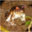

6


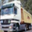

9


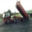

9


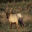

4


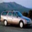

1


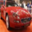

1


In [3]:
print('CIFAR-10')
for i in range(6):
    im = Image.fromarray(ci10Tr_X[i])
    display(im)
    print(ci10Tr_Y[i])
    im.save('cifar10_{}.pdf'.format(i))

## Image_net_crop and Image_net_resize

Image net crop


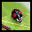

10.0


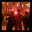

10.0


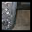

10.0


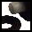

10.0


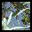

10.0


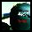

10.0
Image net resize


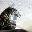

10.0


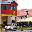

10.0


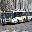

10.0


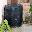

10.0


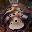

10.0


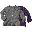

10.0
imgNCr_X shape (10000, 32, 32, 3)
imgNRe_X shape (10000, 32, 32, 3)


In [4]:
def load_img_eval(data_path, img_type):
    data_list = []
    with tarfile.open(data_path) as tar:
        filename_list = tar.getnames()
        for filename in filename_list:
            if img_type in filename:
                tar_file = tar.extractfile(filename)
                tar_data = tar_file.read()
                bytes_io = BytesIO(tar_data)
                pil_img = Image.open(bytes_io)
                pil_img = pil_img.resize((32, 32))
                pil_img_np = np.array(pil_img)
                
                if len(pil_img_np.shape) < 3:
                    pil_img = pil_img.convert('RGB')
                    pil_img_np = np.array(pil_img)
                data_list.append(pil_img_np)
    return data_list

imgN_crop_data_path = 'data/1_raw/imagenet/Imagenet.tar.gz'
imgN_resi_data_path = 'data/1_raw/imagenet/Imagenet_resize.tar.gz'

imgNCr_X = load_img_eval(imgN_crop_data_path, '.png')
imgNCr_Y = np.zeros(len(imgNCr_X)) + 10
imgNRe_X = load_img_eval(imgN_resi_data_path, '.jpg')
imgNRe_Y = np.zeros(len(imgNRe_X)) + 10

print('Image net crop')
for i in range(6):
    im = Image.fromarray(np.uint8(imgNCr_X[i]))
    display(im)
    print(imgNCr_Y[i])
    im.save('imgNCr_{}.pdf'.format(i))

print('Image net resize')
for i in range(6):
    im = Image.fromarray(np.uint8(imgNRe_X[i]))
    display(im)
    print(imgNRe_Y[i])
    im.save('imgNRe_{}.pdf'.format(i))
    
imgNCr_X = np.array(imgNCr_X)
print('imgNCr_X shape', imgNCr_X.shape)

imgNRe_X = np.array(imgNRe_X)
print('imgNRe_X shape', imgNRe_X.shape)

## LSUN_resize and LSUN_crop

LSUN crop


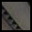

10.0


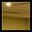

10.0


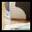

10.0


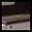

10.0


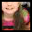

10.0


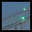

10.0
LSUN resize


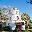

10.0


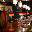

10.0


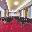

10.0


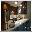

10.0


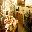

10.0


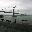

10.0
LSUNCr_X shape (10000, 32, 32, 3)
LSUNRe_X shape (10000, 32, 32, 3)


In [5]:
LSUN_crop_data_path = 'data/1_raw/lsun/LSUN.tar.gz'
LSUN_resi_data_path = 'data/1_raw/lsun/LSUN_resize.tar.gz'

LSUNCr_X = load_img_eval(LSUN_crop_data_path, '.png')
LSUNRe_X = load_img_eval(LSUN_resi_data_path, '.jpg')

LSUNCr_Y = np.zeros(len(LSUNCr_X)) + 10
LSUNRe_Y = np.zeros(len(LSUNRe_X)) + 10

print('LSUN crop')
for i in range(6):
    im = Image.fromarray(np.uint8(LSUNCr_X[i]))
    display(im)
    print(LSUNCr_Y[i])
    im.save('LSUNCr_{}.pdf'.format(i))

print('LSUN resize')
for i in range(6):
    im = Image.fromarray(np.uint8(LSUNRe_X[i]))
    display(im)
    print(LSUNRe_Y[i])
    im.save('LSUNRe_{}.pdf'.format(i))
LSUNCr_X = np.array(LSUNCr_X)
print('LSUNCr_X shape', LSUNCr_X.shape)

LSUNRe_X = np.array(LSUNRe_X)
print('LSUNRe_X shape', LSUNRe_X.shape)

# Encoding with Different ResNet18

In [6]:
from encoding.models.resnet import ResNet18

In [7]:
def image_data_to_dataloader(X_np, Y_np):

    t_norm = transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2023, 0.1994, 0.2010))
    tensor_x = torch.Tensor(X_np / 255.0)
    tensor_x = tensor_x.permute(0, 3, 1, 2)
    tensor_y = torch.Tensor(Y_np.astype(int))
    tensor_y = tensor_y.long()

    dataset = TensorDataset(t_norm(tensor_x), tensor_y)
    dataloader = DataLoader(dataset,
                            batch_size=128,
                            shuffle=True,
                            num_workers=2)
    return dataloader


def encoding(dataloader, net, device):
    output_x_np_list = []
    output_y_np_list = []
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device)
        outputs = net(inputs)
        outputs_np = torch.Tensor.cpu(outputs).detach().numpy()
        output_x_np_list.append(outputs_np)
        output_y_np_list.append(targets.numpy())

    encode_x_np = np.vstack(output_x_np_list)
    encode_y_np = np.hstack(output_y_np_list)
    encode_y_np = encode_y_np.reshape(encode_y_np.shape[0], 1)

    encode_XY = np.hstack([encode_x_np, encode_y_np])
    return encode_XY

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
encoder = ResNet18()
encoder = encoder.to(device)
if device == 'cuda':
    encoder = torch.nn.DataParallel(encoder)
    cudnn.benchmark = True
    
checkpoint = torch.load('./encoding/checkpoint/ckpt.pth')
encoder.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [9]:
dataloader_ci10Tr = image_data_to_dataloader(ci10Tr_X, ci10Tr_Y)
dataloader_ci10Te = image_data_to_dataloader(ci10Te_X, ci10Te_Y)
dataloader_imgNCr = image_data_to_dataloader(imgNCr_X, imgNCr_Y)
dataloader_imgNRe = image_data_to_dataloader(imgNRe_X, imgNRe_Y)
dataloader_LSUNCr = image_data_to_dataloader(LSUNCr_X, LSUNCr_Y)
dataloader_LSUNRe = image_data_to_dataloader(LSUNRe_X, LSUNRe_Y)

In [10]:
e_ci10Tr_XY = encoding(dataloader_ci10Tr, encoder,device)
e_ci10Te_XY = encoding(dataloader_ci10Te, encoder,device)
e_imgNCr_XY = encoding(dataloader_imgNCr, encoder,device)
e_imgNRe_XY = encoding(dataloader_imgNRe, encoder,device)
e_LSUNCr_XY = encoding(dataloader_LSUNCr, encoder,device)
e_LSUNRe_XY = encoding(dataloader_LSUNRe, encoder,device)

# Openset Sample Enrichment

In [11]:
from aosr_utility import sample_enrichment_IF

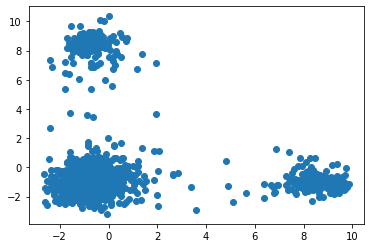

/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


(149042,)


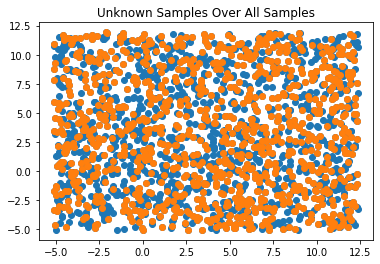

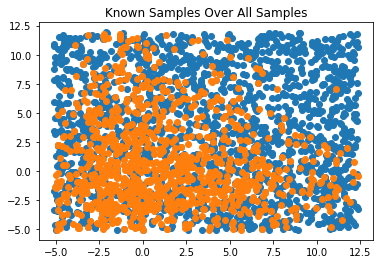

In [12]:
tf.random.set_seed(0)

plt.scatter(e_ci10Tr_XY[:2000, 0], e_ci10Tr_XY[:2000, 1])
plt.show()

z_q_sample, z_q_weight = sample_enrichment_IF(0, e_ci10Tr_XY[:,:-1], 240000)
z_q_weight = 1 - z_q_weight * 1.0

tau = np.sort(z_q_weight)[int(z_q_weight.shape[0] *.1)]

# Unknown Samples
cond1 = (z_q_weight > tau)
cond1 = np.squeeze(cond1)
# Known Samples
cond2 = (z_q_weight <= tau)
cond2 = np.squeeze(cond2)
# Wipe Known Samples
z_q_weight[cond2] = 0
# Balance the weights
z_q_weight = z_q_weight * (z_q_weight.shape[0] / z_q_weight.sum())

plt.scatter(z_q_sample[:2000, 0], z_q_sample[:2000, 1])
plt.scatter(z_q_sample[cond1, 0][:1000], z_q_sample[cond1, 1][:1000])
plt.title('Unknown Samples Over All Samples')
plt.show()
plt.scatter(z_q_sample[:2000, 0], z_q_sample[:2000, 1])
plt.scatter(z_q_sample[cond2, 0][:1000], z_q_sample[cond2, 1][:1000])
plt.title('Known Samples Over All Samples')
plt.show()

# Openset Learning

In [13]:
from aosr_utility import aosr_risk

In [14]:
def cifar10_exp(r_seed):
    # ================================================================== #
    #                                 FYI                                #
    # Design the Open-set Learning Model is a complicated task           #
    # At this stage, we only evaluate the openset learning loss          #
    # How to design proper openset model is consider as our future work  #
    # Since we use the closed-set output as our encoder, the Open-set    # 
    # the Open-set neural network is relatively simple                   #
    # ================================================================== #
    set_random_seed(r_seed, device)
    detetor = tf.keras.models.Sequential([
        tf.keras.layers.Dense(11),
        tf.keras.layers.Activation(activation='softmax')
    ])

    detetor.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    detetor.fit(e_ci10Tr_XY[:,:-1], e_ci10Tr_XY[:,-1] * 1.0, epochs=2)

    detetor.compile(optimizer='adam',
                    loss=aosr_risk(detetor, z_q_sample, z_q_weight, e_ci10Tr_XY[:,:-1], 0.15, 10),
                    metrics=['accuracy'])

    K.set_value(detetor.optimizer.learning_rate, 0.001)
    detetor.fit(e_ci10Tr_XY[:,:-1], e_ci10Tr_XY[:,-1], epochs=30)


    ci10Te_pred = detetor.predict(e_ci10Te_XY[:,:-1])
    ci10Te_pred = ci10Te_pred.argmax(axis=1)
    print('ci10Te acc', accuracy_score(e_ci10Te_XY[:,-1], ci10Te_pred))

    ci10Tr_pred = detetor.predict(e_ci10Tr_XY[:,:-1])
    ci10Tr_pred = ci10Tr_pred.argmax(axis=1)
    print('ci10Tr detection rate', (ci10Tr_pred == 10).sum() / 50000)
    print('ci10Te detection rate', (ci10Te_pred == 10).sum() / 10000)
    
    e_imgNCr_XY = encoding(dataloader_imgNCr, encoder,device)
    e_imgNRe_XY = encoding(dataloader_imgNRe, encoder,device)
    e_LSUNCr_XY = encoding(dataloader_LSUNCr, encoder,device)
    e_LSUNRe_XY = encoding(dataloader_LSUNRe, encoder,device)

    imgNCr_pred = detetor.predict(e_imgNCr_XY[:,:-1])
    imgNCr_pred = imgNCr_pred.argmax(axis=1)
    print('imgNCr detection rate', (imgNCr_pred == 10).sum() / 10000)
    imgNRe_pred = detetor.predict(e_imgNRe_XY[:,:-1])
    imgNRe_pred = imgNRe_pred.argmax(axis=1)
    print('imgNRe detection rate', (imgNRe_pred == 10).sum() / 10000)

    LSUNCr_pred = detetor.predict(e_LSUNCr_XY[:,:-1])
    LSUNCr_pred = LSUNCr_pred.argmax(axis=1)
    print('LSUNCr detection rate', (LSUNCr_pred == 10).sum() / 10000)
    LSUNRe_pred = detetor.predict(e_LSUNRe_XY[:,:-1])
    LSUNRe_pred = LSUNRe_pred.argmax(axis=1)
    print('LSUNRe detection rate', (LSUNRe_pred == 10).sum() / 10000)
    

    sample_size = 10000
    true_label = np.zeros(sample_size*2) + 10
    true_label[:sample_size] = e_ci10Te_XY[:,-1]

    imgNCr_f1 = f1_score(true_label, np.concatenate([ci10Te_pred,imgNCr_pred]), average='macro')
    imgNRe_f1 = f1_score(true_label, np.concatenate([ci10Te_pred,imgNRe_pred]), average='macro')
    LSUNCr_f1 = f1_score(true_label, np.concatenate([ci10Te_pred,LSUNCr_pred]), average='macro')
    LSUNRe_f1 = f1_score(true_label, np.concatenate([ci10Te_pred,LSUNRe_pred]), average='macro')

    playground_result = pd.DataFrame()
    playground_result['detector'] = ['aosr_risk']
    playground_result['imgNCr_f1'] = [imgNCr_f1]
    playground_result['imgNRe_f1'] = [imgNRe_f1]
    playground_result['LSUNCr_f1'] = [LSUNCr_f1]
    playground_result['LSUNRe_f1'] = [LSUNRe_f1]
    return playground_result

In [15]:
result_list =[]
result_list.append(cifar10_exp(0))
result_list.append(cifar10_exp(1))
result_list.append(cifar10_exp(2))
result_list.append(cifar10_exp(3))
result_list.append(cifar10_exp(4))
result = pd.concat(result_list, axis=0)
print(result.mean())
print(result.std())
result

Epoch 1/2
1563/1563 [==============================] - 2s 808us/step - loss: 1.0591 - accuracy: 0.7017
Epoch 2/2
1563/1563 [==============================] - 1s 857us/step - loss: 0.0348 - accuracy: 0.9935
Epoch 1/30
1563/1563 [==============================] - 4s 2ms/step - loss: 85529012.9003 - accuracy: 0.9948
Epoch 2/30
1563/1563 [==============================] - 3s 2ms/step - loss: 1106.0802 - accuracy: 0.9936
Epoch 3/30
1563/1563 [==============================] - 3s 2ms/step - loss: 1043.9851 - accuracy: 0.9937
Epoch 4/30
1563/1563 [==============================] - 3s 2ms/step - loss: 552.1789 - accuracy: 0.9930
Epoch 5/30
1563/1563 [==============================] - 3s 2ms/step - loss: 551.1969 - accuracy: 0.9939
Epoch 6/30
1563/1563 [==============================] - 3s 2ms/step - loss: 549.0662 - accuracy: 0.9937
Epoch 7/30
1563/1563 [==============================] - 3s 2ms/step - loss: 488.7795 - accuracy: 0.9937
Epoch 8/30
1563/1563 [==============================] - 3s 

1563/1563 [==============================] - 3s 2ms/step - loss: 1.0272 - accuracy: 0.9885
Epoch 22/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.8362 - accuracy: 0.9876
Epoch 23/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.7207 - accuracy: 0.9852
Epoch 24/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6542 - accuracy: 0.9838
Epoch 25/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6185 - accuracy: 0.9823
Epoch 26/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.6014 - accuracy: 0.9822
Epoch 27/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5972 - accuracy: 0.9819
Epoch 28/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5955 - accuracy: 0.9823
Epoch 29/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5944 - accuracy: 0.9824
Epoch 30/30
1563/1563 [==============================] - 3s 2ms/step - loss: 0.5920 -

,detector,imgNCr_f1,imgNRe_f1,LSUNCr_f1,LSUNRe_f1
0,aosr_risk,0.756650,0.745495,0.784548,0.763328
0,aosr_risk,0.756722,0.743671,0.786109,0.760977
0,aosr_risk,0.757751,0.744719,0.785652,0.762678
0,aosr_risk,0.759052,0.745340,0.784815,0.761571
0,aosr_risk,0.758182,0.745901,0.785796,0.762324
